In [1]:
import sys
sys.path.insert(1, '../scripts')

In [2]:
# data processing
import os.path
from os import path
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import parseaf as pa

# logistic regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# figure making
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## Functions

In [5]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [6]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

## Training logistic regression model using AlphaFold data

In [7]:
df = pd.read_csv('../../data/af_regions/sc_af_regions_all.csv')

In [8]:
for aa in states:
    df['freq_'+aa] = df.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [9]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = df[featurecol]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_all = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9246841593780369

In [10]:
logreg.score(X, y)

0.9279033041788144

In [11]:
logreg.coef_

array([[  5.7975161 ,   0.86276564, -10.35312711,   1.44558562,
          6.7005998 ,  -6.87920526,  -4.12201391,  12.87533155,
          0.54584577,  14.81381289,   3.1715153 ,  -8.7484139 ,
        -21.42989215,   2.72749466,   0.86247885, -10.79848695,
         -5.03842816,   5.93401894,   4.67349266,   6.9277776 ]])

In [12]:
df_lr = pd.DataFrame(columns=['aa','coef'])
for i in range(20):
    df_lr = df_lr.append({'aa': states[i], 'coef': logreg.coef_[0][i]}, ignore_index=True)

In [13]:
df_lr = df_lr.sort_values(by='coef', ascending=False, key=abs)

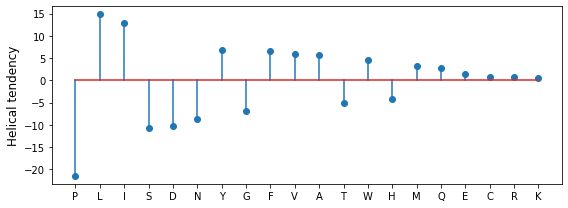

In [14]:
plt.figure(figsize=(8,3))
plt.stem(df_lr['aa'], df_lr['coef'])
plt.ylabel('Helical tendency', fontsize=12)
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.show()

## Helical propensity scale

In [15]:
df_hp = pd.read_csv('../../data/misc/helix_propensity_pace1998.txt')

In [16]:
h_propensity = {}
for index, row in df_hp.iterrows():
    h_propensity[row['aa']] = row['hp']

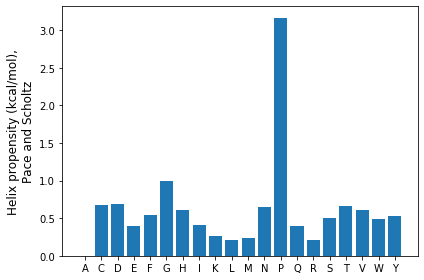

In [17]:
plt.figure()
plt.bar(h_propensity.keys(), h_propensity.values())
plt.ylabel('Helix propensity (kcal/mol),\nPace and Scholtz', fontsize=12)
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.show()

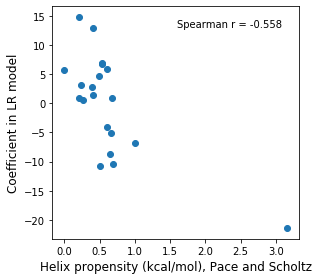

In [18]:
plt.figure(figsize=(4.5,4))
plt.scatter(h_propensity.values(), logreg.coef_.tolist())
plt.xlabel('Helix propensity (kcal/mol), Pace and Scholtz', fontsize=12)
plt.ylabel('Coefficient in LR model', fontsize=12)
corr = stats.spearmanr(list(h_propensity.values()), logreg.coef_[0].tolist())
plt.text(1.6, 13, "Spearman r = " + '{0:.3g}'.format(corr.correlation))
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.show()

## Re-train model using residues with top coefficients as predictors

In [19]:
def get_logreg_accuracy(df, aa_list):
    featurecol = []
    for aa in aa_list:
        featurecol.append('freq_'+aa)
    X = df[featurecol]
    y = df['label']
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    return cnf_matrix, accuracy

In [20]:
states_ranked = df_lr['aa'].tolist()

In [21]:
acc_list = []
pred_aas = []
for i in range(1,21):
    aa_list = states_ranked[:i]
    accuracy = get_logreg_accuracy(df, aa_list)[1]
    acc_list.append(accuracy)
    pred_aas.append('top '+ str(i))

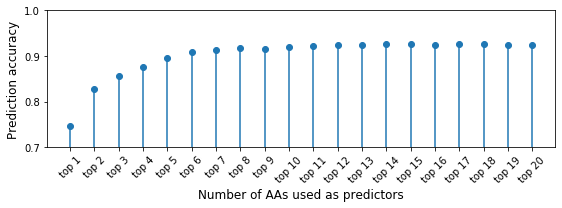

In [22]:
plt.figure(figsize=(8, 3))
plt.stem(pred_aas, acc_list)
plt.ylabel('Prediction accuracy', fontsize=12)
plt.xlabel('Number of AAs used as predictors', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.show()

## Using only P or using only P and G

In [23]:
d_acc = {}

In [24]:
d_acc['sc_top5'] = acc_list[4]

In [25]:
d_acc['sc_onlyP'] = acc_list[0]

In [26]:
d_acc['sc_onlyPG'] = get_logreg_accuracy(df, ['P', 'G'])[1]

In [27]:
d_acc

{'sc_top5': 0.8965014577259475,
 'sc_onlyP': 0.7468415937803693,
 'sc_onlyPG': 0.7560738581146744}

## Using model trained on all AF output to classify random non-highly-charged regions

In [28]:
df_random = pd.read_csv('../../data/af_regions/random_af_regions_low_thresh.csv')

In [29]:
def append_percent_aa(row, aa):
    seq = row['seq']
    return get_aa_freq(seq, aa)

In [30]:
for aa in states:
    df_random['freq_'+aa] = df_random.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [31]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X_rd = df_random[featurecol]
y_rd = df_random['label']
y_pred_rd = logreg.predict(X_rd)
cnf_rd = metrics.confusion_matrix(y_rd, y_pred_rd)
accuracy = metrics.accuracy_score(y_rd, y_pred_rd)
accuracy

0.8689655172413793

In [32]:
cnf_rd

array([[2422,  128],
       [ 385,  980]])

## Labelling highly charged regions based on AlphaFold output

In [33]:
def append_structure_label(row):
    fdir = '/mnt/d/research/drummond-lab/data/cerevisiae-alphafold-output/'
    uni_id = row['uni_id']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    label = pa.get_structure_label(fdir, uni_id, left_bound, right_bound)
    return label

In [34]:
def append_percent_structure(row):
    uniprot_id = row['uni_id']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    fdir = '/mnt/d/research/drummond-lab/data/cerevisiae-alphafold-output/'
    fpath = fdir + 'AF-' + str(uniprot_id) + '-F1-model_v1.pdb'
    if path.exists(fpath):
        af_pdb = pa.read_af_output(fdir, uniprot_id)
        ss = md.compute_dssp(af_pdb, simplified=True)[0]
        region_ss = ss[left_bound:(right_bound+1)]
        bfactor = pa.read_bfactor_from_pdb(fpath)[left_bound:(right_bound+1)]
        len_region = right_bound - left_bound + 1

        p_helix = pa.get_percent_helix(region_ss, bfactor, len_region)
        p_disorder = pa.get_percent_disorder(region_ss, bfactor, len_region)
        
        cnt_sheets = 0
        for i, label in enumerate(region_ss):
            if (label == 'E') and (bfactor[i] >= 70):
                cnt_sheets += 1
        p_sheets = cnt_sheets / len_region
    return pd.Series(dict(p_helix=p_helix, p_disorder=p_disorder, p_sheets=p_sheets))

In [35]:
#df_hc = pd.read_csv('../../data/charged_regions/cr_filtered.csv', comment='#')
#df_hc['label'] = df_hc.apply(lambda row: append_structure_label(row), axis=1)
#unlabeled = df_hc[df_hc.label == 'unclassified']
#unlabeled = unlabeled.join(unlabeled.apply(append_percent_structure, axis="columns"))
#unlabeled.to_csv('../../data/charged_regions/cr_filtered_unlabeled.csv', index=False)

In [36]:
unlabeled = pd.read_csv('../../data/charged_regions/cr_filtered_unlabeled.csv')

In [37]:
unlabeled

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,label,p_helix,p_disorder,p_sheets
0,YAL011W,SWC3,626,470,525,KSVVEFLEDTDEIIISWIVIHNSKEIEKFKTKKIKAKLKADQKLNK...,56,0.000000,0.428571,0.114622,0.300249,P31376,verified,unclassified,0.339286,0.392857,0.267857
1,YAR042W,SWH1,1189,1100,1155,LAPTDSRLRPDQRAMENGEYDKAAAEKHRVEVKQRAAKKEREQKGE...,56,0.002747,0.464286,0.038024,0.090131,P35845,verified,unclassified,0.589286,0.321429,0.089286
2,YBL007C,SLA1,1245,549,624,TGFSLEKFKANDGSSSRGTDSRDSERERRRRLKEQEEKERDRRLKE...,76,0.002754,0.565789,0.046616,0.085134,P32790,verified,unclassified,0.592105,0.407895,0.000000
3,YBL078C,ATG8,118,3,53,TFKSEYPFEKRKAESERIADRFKNRIPVICEKAEKSDIPEIDKRKY...,51,0.003268,0.470588,0.046144,0.108555,P38182,verified,unclassified,0.372549,0.372549,0.254902
4,YBR023C,CHS3,1166,1119,1164,IAGGNKKAQDENEGEFDHSKIKMRTWREFEREDILNRKEESDSFVA,46,0.009317,0.456522,0.109843,0.277843,P29465,verified,unclassified,0.456522,0.500000,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,YPL226W,NEW1,1197,1134,1179,NLAKPSVDDDDSPANIKVKQRKKRLTRNEKKLQAERRRLRYIEWLS,46,0.050725,0.456522,0.161465,0.449582,Q08972,verified,unclassified,0.434783,0.565217,0.000000
145,YPR107C,YTH1,209,153,204,GFCPLGKDECDMEHPQFIIPDEGSKLRIKRDDEINTRKMDEEKERR...,52,0.007525,0.442308,0.078459,0.202338,Q06102,verified,unclassified,0.500000,0.480769,0.019231
146,YPR110C,RPC40,336,253,296,GVIGIDEGSDEAYVKDARKDTVSREVLRYEEFADKVKLGRVRNH,44,0.001196,0.431818,0.084225,0.228311,P07703,verified,unclassified,0.227273,0.409091,0.363636
147,YPR112C,MRD1,888,98,153,RVPQPMKEKRREALKRFREKEEKLLQEENRKKKKVDENKHSNIDDE...,56,0.020089,0.571429,0.089393,0.169530,Q06106,verified,unclassified,0.535714,0.464286,0.000000


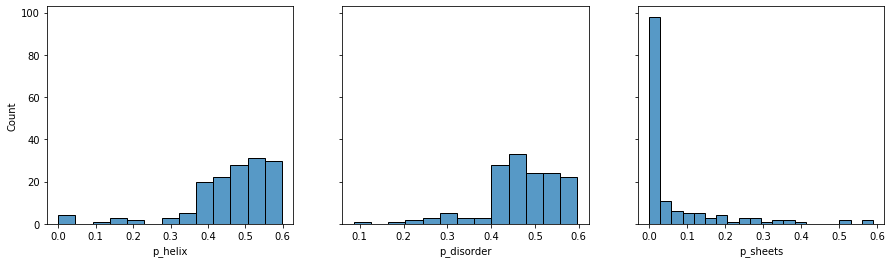

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
sns.histplot(unlabeled['p_helix'], ax=axes[0])
sns.histplot(unlabeled['p_disorder'], ax=axes[1])
sns.histplot(unlabeled['p_sheets'], ax=axes[2])
plt.show()

In [39]:
unlabeled[(unlabeled.p_helix < 0.1) & (unlabeled.p_disorder < 0.1)]

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,label,p_helix,p_disorder,p_sheets
87,YKL021C,MAK11,469,409,466,IEKYNTMKKRDAETADIGDQSEVESDTEELKKIMFGEKKKLNKKKR...,58,0.014863,0.5,0.186732,0.412716,P20484,verified,unclassified,0.0,0.086207,0.0


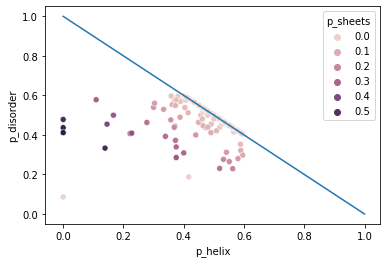

In [40]:
plt.figure()
sns.scatterplot(unlabeled['p_helix'], unlabeled['p_disorder'], hue=unlabeled['p_sheets'])
x = np.linspace(0, 1, 1000)
y = np.linspace(1, 0, 1000)
plt.plot(x, y)
plt.show()

In [41]:
#df_hc = df_hc[df_hc.label != 'unclassified']
#df_hc = df_hc.dropna(how='any')
#df_hc.to_csv('../../data/charged_regions/cr_filtered_aflabel.csv', index=False)

## Using model trained on all AF output to classify highly charged regions

In [42]:
def append_percent_aa(row, aa):
    seq = row['region.seq']
    return get_aa_freq(seq, aa)

In [43]:
df_hc = pd.read_csv('../../data/charged_regions/cr_filtered_aflabel.csv')

In [44]:
for aa in states:
    df_hc['freq_'+aa] = df_hc.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [45]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X_hc = df_hc[featurecol]
y_hc = df_hc['label']
y_pred_hc = logreg.predict(X_hc)
cnf_hc = metrics.confusion_matrix(y_hc, y_pred_hc)
accuracy = metrics.accuracy_score(y_hc, y_pred_hc)
accuracy

0.8786717752234994

In [46]:
cnf_hc

array([[489,  21],
       [ 74, 199]])

In [47]:
df_hc['lr_label'] = y_pred_hc

In [48]:
len(df_hc)

783

In [49]:
len(df_hc[((df_hc.label == 'disordered') & (df_hc.lr_label == 'disordered')) |\
          ((df_hc.label == 'helix') & (df_hc.lr_label == 'helix'))])

688

In [50]:
df_hc.to_csv('../../data/charged_regions/cr_filtered_lrlabel.csv')

In [51]:
df_hc.drop(columns=featurecol)

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,label,lr_label
0,YAL011W,SWC3,626,0,54,MPAVLRTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDD...,55,0.015674,0.527273,0.297167,0.616928,P31376,verified,disordered,disordered
1,YAL011W,SWC3,626,169,265,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,97,0.050753,0.536082,0.051716,0.110243,P31376,verified,helix,helix
2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,0.044964,0.096912,P31376,verified,disordered,disordered
3,YAL013W,DEP1,406,81,163,TLTESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAI...,83,0.141633,0.542169,0.093375,0.239955,P31385,verified,disordered,disordered
4,YAL019W,FUN30,1132,457,539,PAPAPVERETKRIRNTTKPKVVEDEDDDVDLEAIDDELPQSEHEDD...,83,0.267765,0.590361,0.175213,0.534439,P31380,verified,disordered,disordered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,YPR163C,TIF3,437,379,433,SVYDVLRTEDDDEDEEAEKQNGDAKENKVDAAVEKLQDKTAQLTVE...,55,0.122909,0.454545,0.115449,0.366767,P34167,verified,disordered,disordered
779,YPR169W,JIP5,493,434,491,LVGLSKEELLDELDKDLKEDHQEEKESNSKSVKKRKIMKENNKKKD...,58,0.000556,0.534483,0.111450,0.219531,Q06214,verified,disordered,disordered
780,YPR179C,HDA3,656,512,577,GETLSKLKDAFVKTDNVQDEIEKEERVSVSRDTEKKYMEQEIKRAV...,66,0.012219,0.469697,0.045506,0.106750,Q06623,verified,helix,disordered
781,YPR186C,PZF1,430,370,411,NCSRTFKTKEKYEKHIDKHKVHELKLKILQEKEENKTLVDQN,42,0.011278,0.452381,0.031155,0.081428,P39933,verified,helix,helix


## Confusion matrices summary figure

In [52]:
uv_all = pd.read_csv('../../data/uversky/uversky_all.csv')
uv_rd = pd.read_csv('../../data/uversky/uversky_random.csv')
uv_hc = pd.read_csv('../../data/uversky/uversky_hc.csv')
df_uv = [uv_all, uv_rd, uv_hc]

In [53]:
cnf_uv_all = np.array([[0, 0], [0, 0]])
cnf_uv_rd = np.array([[0, 0], [0, 0]])
cnf_uv_hc = np.array([[0, 0], [0, 0]])
cnf_uv = [cnf_uv_all, cnf_uv_rd, cnf_uv_hc]

In [54]:
for i in range(3):
    df = df_uv[i]
    cnf = cnf_uv[i]
    cnf[0, 0] = len(df[(df.label == 'disordered') & (df.uversky_pred == 'disordered')])
    cnf[0, 1] = len(df[(df.label == 'disordered') & (df.uversky_pred == 'helix')])
    cnf[1, 0] = len(df[(df.label == 'helix') & (df.uversky_pred == 'disordered')])
    cnf[1, 1] = len(df[(df.label == 'helix') & (df.uversky_pred == 'helix')])

In [55]:
sample_size = []
for df in df_uv:
    sample_size.append(len(df))

In [56]:
sample_size

[16464, 3915, 783]

In [57]:
def get_cnf_freq(cnf_mat):
    cnf_freq = cnf_mat / cnf_mat.sum(axis=1)[:, np.newaxis]
    return cnf_freq

In [58]:
titles = ['All regions\nlabelled under\nstringent conditions',
          'Random regions\nlabelled under\nrelaxed conditions',
          'Highly charged regions\nlabelled under\nrelaxed conditions']
for i, title in enumerate(titles):
    titles[i] = title + '\nn = ' + str(sample_size[i])

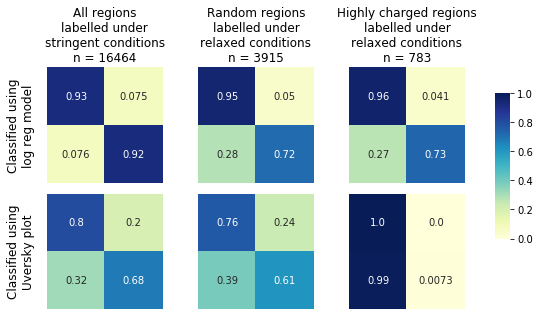

In [59]:
fig, axes = plt.subplots(2,3, figsize=(7, 4.5))
cbar_ax = fig.add_axes([1, .25, .03, .45])

cnf_matrices = [cnf_all, cnf_rd, cnf_hc] + cnf_uv
for i, ax in enumerate(axes.flat):
    g = sns.heatmap(pd.DataFrame(get_cnf_freq(cnf_matrices[i])), ax=ax,
                    square=True, annot=True, fmt=".2",
                    xticklabels=['', ''], yticklabels=['', ''],
                    cmap="YlGnBu", cbar= (i == 0),
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)
    g.tick_params(left=False, bottom=False)
    if i < 3:
        g.set_title(titles[i], y=1.2)
    #ax.title.set_position([.5, 0.8])
    if i == 0:
        ax.set_ylabel('Classified using\nlog reg model', fontsize=12)
        ax.yaxis.labelpad = 5
    elif i == 3:
        ax.set_ylabel('Classified using\nUversky plot', fontsize=12)
        ax.yaxis.labelpad = 5
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()

## Summary plot for accuracy score

In [60]:
l_acc = []
for i in range(6):
    cnf = cnf_matrices[i]
    accuracy = (cnf[0, 0] + cnf[1, 1]) / np.sum(cnf)
    l_acc.append(accuracy)

In [61]:
ticks = ['Using LR model\nto classify all regions',
         'Using LR model\nto classify random regions',
         'Using LR model\nto classify highly charged regions',
         'Using Uverskey plot\nto classify all regions',
         'Using Uverskey plot\nto classify random regions',
         'Using Uverskey plot\nto classify highly charged regions']

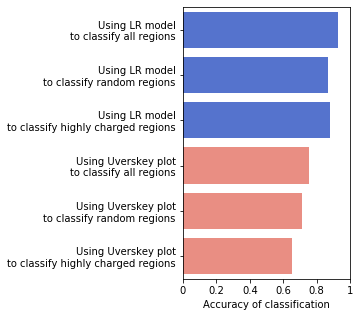

In [62]:
fig, ax = plt.subplots(figsize=(3,5))
ax = sns.barplot(y=ticks, x=l_acc,
                 palette=['royalblue', 'royalblue', 'royalblue', 'salmon', 'salmon', 'salmon'])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlim(0, 1)
ax.set_xlabel('Accuracy of classification')
plt.show()

In [63]:
sc_acc = np.mean(l_acc[:3])
sc_acc

0.8907738172809719

## Using model trained on all AF output to classify pombe regions

In [64]:
df_pombe = pd.read_csv('../../data/af_regions/pombe_af_regions.csv')

In [65]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    return get_aa_freq(seq, aa)

In [66]:
for aa in states:
    df_pombe['freq_'+aa] = df_pombe.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [67]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)

In [68]:
X_p = df_pombe[featurecol]
y_p = df_pombe['label']

In [69]:
y_pred_p = logreg.predict(X_p)
cnf_matrix_p = metrics.confusion_matrix(y_p, y_pred_p)
accuracy = metrics.accuracy_score(y_p, y_pred_p)

In [70]:
cnf_freq_p = cnf_matrix_p / cnf_matrix_p.sum(axis=1)[:, np.newaxis]
cnf_freq_p

array([[0.9064194 , 0.0935806 ],
       [0.08997476, 0.91002524]])

In [71]:
accuracy

0.9080121057661675

In [72]:
d_acc['pombe'] = accuracy

## Using model trained on all AF output to classify human regions

In [73]:
df_hs = pd.read_csv('../../data/af_regions/hsapiens_af_regions.csv')

In [74]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    return get_aa_freq(seq, aa)

In [75]:
for aa in states:
    df_hs['freq_'+aa] = df_hs.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [76]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)

In [77]:
X_h = df_hs[featurecol]
y_h = df_hs['label']

In [78]:
y_pred_h = logreg.predict(X_h)
cnf_matrix_h = metrics.confusion_matrix(y_h, y_pred_h)
accuracy = metrics.accuracy_score(y_h, y_pred_h)

In [79]:
accuracy

0.9397504456327985

In [80]:
d_acc['human'] = accuracy

## Summary figure for accuracy

In [81]:
d_acc

{'sc_top5': 0.8965014577259475,
 'sc_onlyP': 0.7468415937803693,
 'sc_onlyPG': 0.7560738581146744,
 'pombe': 0.9080121057661675,
 'human': 0.9397504456327985}

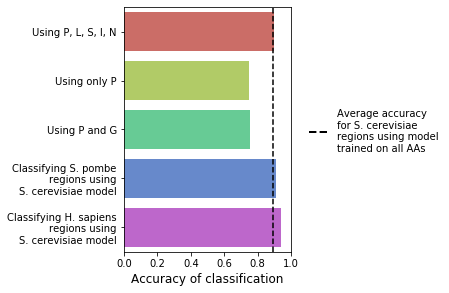

In [82]:
fig, ax = plt.subplots(figsize=(3,4.5))
keys = list(d_acc.keys())
vals = [d_acc[k] for k in keys]
ax = sns.barplot(y=keys, x=vals, palette="hls")
ax.set_yticklabels(['Using P, L, S, I, N', 'Using only P', 'Using P and G',
                    'Classifying S. pombe\nregions using\nS. cerevisiae model',
                    'Classifying H. sapiens\nregions using\nS. cerevisiae model'])
ax.set_xlabel('Accuracy of classification', fontsize=12)
ax.set_xlim(0, 1)
plt.axvline(sc_acc, color='black', linestyle='dashed')
plt.legend([Line2D([0], [0], color='black', lw=2, ls='dashed')],
           ['Average accuracy\nfor S. cerevisiae\nregions using model\ntrained on all AAs'],
          bbox_to_anchor=(1.05, 0.62), frameon=False)
plt.show()